Files already downloaded and verified
Files already downloaded and verified
Input image is 33x33 size with 3 channels
Classes of data are:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


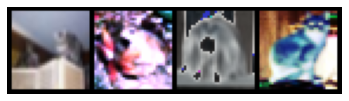

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from autoaugment import ImageNetPolicy

img_size = 33
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)), ImageNetPolicy(), 
                                transforms.RandomHorizontalFlip(), transforms.ToTensor(),   
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),   
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print(f"Input image is {images.size()[-2]}x{images.size()[-1]} size with {images.size()[-3]} channels")
print('Classes of data are: ',train_set.classes)

# show images
plt.axis("off")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [2]:
import torch.optim as optim
from ViT_pytorch import *
from vision_train import *

cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda else "cpu")

# Tested Smaller version than ViT-Base
model = ViT(channel_input=3, patch_size=11, embedding_dim=768, img_size=img_size, 
            depth=12, num_head=12, ffn_expansion=4, drop_p=0.2, num_class=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Set to train : trained with CutMix & MixUp techniques
trainer = AugTrainer(model=model, optim=optimizer, scheduler=scheduler, train_loader=train_loader, 
                    val_loader=test_loader, test_loader=test_loader, device=device)

# Check number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters : {pytorch_total_params}")

trainer.train(n_epoch=200, verbose_freq=50, aug_rate=0.2)
test_loss, test_acc = trainer.test_acc()
print(f'Test accuracy : {test_acc}%')

Number of model parameters : 7385098


  0%|          | 0/200 [00:00<?, ?it/s]

===> Epoch: 50 / Avg train loss: 1.921 / Train acc: 32.486% / Avg val loss: 1.368 / Val acc: 54.100%
===> Epoch: 100 / Avg train loss: 2.026 / Train acc: 27.528% / Avg val loss: 1.614 / Val acc: 44.610%
===> Epoch: 150 / Avg train loss: 1.852 / Train acc: 35.570% / Avg val loss: 1.348 / Val acc: 55.410%
===> Epoch: 200 / Avg train loss: 1.745 / Train acc: 40.146% / Avg val loss: 1.174 / Val acc: 60.490%
Test accuracy : 60.49%
